float64 int64
np.shape(X/Y): (2, 211) (1, 211) np.shape(X/Ytest): (2, 200)


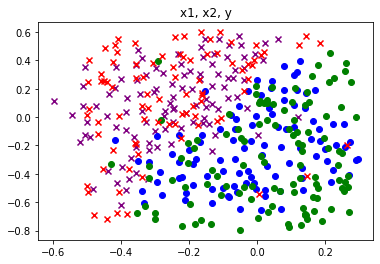

In [1]:
import time
import scipy.io
data = scipy.io.loadmat('datasets/data.mat')
X1 = data['X'].T; Y1 = data['y'].T
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
%matplotlib inline

n0 = 2 # layer 0
n1 = 20 # layer 1
n2 = 3 # layer 2
n3 = 1 # layer 3
m = 300 # layer 4
alpha = 0.01 # learning rate

np.random.seed(3)
#train_X, train_Y = sklearn.datasets.make_circles(n_samples = 300, noise = .05)
#test_X, test_Y = sklearn.datasets.make_circles(n_samples = 60, noise = .05)
#A0 = train_X.T; Y = train_Y.reshape(1,300)
#A0test = test_X.T; Ytest = test_Y.reshape(1,60)
#print("np.shape(Y):",np.shape(Y),"np.shape(A0):",np.shape(A0))
X = X1; Y = np.int64(Y1)
print(X.dtype, Y.dtype)
Xtest = data['Xval'].T; Ytest = data['yval'].T

print("np.shape(X/Y):",np.shape(X),np.shape(Y),"np.shape(X/Ytest):",np.shape(Xtest))

for i in range(np.shape(X)[1]):
    if(Y[0][i] < 0.5):
        plt.scatter(X[0][i], X[1][i], c = "blue", marker = "o")
    else:
        plt.scatter(X[0][i], X[1][i], c = "purple", marker = "x")
for i in range(np.shape(Xtest)[1]):
    if(Ytest[0][i] < 0.5):
        plt.scatter(Xtest[0][i], Xtest[1][i], c = "green", marker = "o")
    else:
        plt.scatter(Xtest[0][i], Xtest[1][i], c = "red", marker = "x")
        
plt.title('x1, x2, y')
plt.show()

In [2]:
def forwardprop(X, parameters):
    A0 = X
    WT1 = parameters["WT1"];
    WT2 = parameters["WT2"];
    WT3 = parameters["WT3"];
    b1 = parameters["b1"];
    b2 = parameters["b2"];
    b3 = parameters["b3"];
    Z1 = np.dot(WT1,A0) + b1
    A1 = np.maximum(0,Z1)
    Z2 = np.dot(WT2,A1) + b2
    A2 = np.maximum(0,Z2)
    Z3 = np.dot(WT3,A2) + b3;
    A3 = 1/(1 + np.exp(-Z3))
    cache = (Z1,A1,WT1,b1,Z2,A2,WT2,b2,Z3,A3,WT3,b3)
    return A3, cache

In [3]:
def forwardprop_dropout(X, parameters, keep_prob = 1):
    np.random.seed(1)
    A0 = X
    WT1 = parameters["WT1"];
    WT2 = parameters["WT2"];
    WT3 = parameters["WT3"];
    b1 = parameters["b1"];
    b2 = parameters["b2"];
    b3 = parameters["b3"];
    
    Z1 = np.dot(WT1,A0) + b1
    A1 = np.maximum(0,Z1)
    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = A1 * D1
    A1 = A1 / keep_prob
    
    Z2 = np.dot(WT2,A1) + b2
    A2 = np.maximum(0,Z2)
    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = A2 * D2
    A2 = A2 / keep_prob
    
    Z3 = np.dot(WT3,A2) + b3;
    A3 = 1/(1 + np.exp(-Z3))
    cache = (Z1,D1,A1,WT1,b1,Z2,D2,A2,WT2,b2,Z3,A3,WT3,b3)
    return A3, cache
    

In [4]:
def backwardprop(X, Y, cache):
    (Z1,A1,WT1,b1,Z2,A2,WT2,b2,Z3,A3,WT3,b3) = cache
    m = X.shape[1]
    dZ3 = A3 - Y
    dWT3 = 1 / m * np.dot(dZ3,A2.T)
    db3 = 1 / m * np.sum(dZ3,axis = 1, keepdims = True)
    dA2 = np.dot(WT3.T,dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dWT2 = 1 / m * np.dot(dZ2,A1.T)
    db2 = 1 / m * np.sum(dZ2, axis = 1, keepdims = True)
    dA1 = np.dot(WT2.T,dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dWT1 = 1 / m * np.dot(dZ1,X.T)
    db1 = 1 / m * np.sum(dZ1, axis = 1, keepdims = True)
    gradients = {"dZ3": dZ3, "dWT3": dWT3, "db3": db3, 
                 "dA2": dA2,"dZ2": dZ2, "dWT2": dWT2, "db2": db2,
                 "dA1": dA1,"dZ1": dZ1, "dWT1": dWT1, "db1": db1}
    return gradients

In [5]:
def backwardprop_L2regular(X, Y, cache,lambd):
    (Z1,A1,WT1,b1,Z2,A2,WT2,b2,Z3,A3,WT3,b3) = cache
    m = X.shape[1]
    dZ3 = A3 - Y
    dWT3 = 1 / m * np.dot(dZ3,A2.T) + lambd / m * WT3
    db3 = 1 / m * np.sum(dZ3,axis = 1, keepdims = True)
    dA2 = np.dot(WT3.T,dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dWT2 = 1 / m * np.dot(dZ2,A1.T) + lambd / m * WT2
    db2 = 1 / m * np.sum(dZ2, axis = 1, keepdims = True)
    dA1 = np.dot(WT2.T,dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dWT1 = 1 / m * np.dot(dZ1,X.T) + lambd / m * WT1
    db1 = 1 / m * np.sum(dZ1, axis = 1, keepdims = True)
    gradients = {"dZ3": dZ3, "dWT3": dWT3, "db3": db3, 
                 "dA2": dA2,"dZ2": dZ2, "dWT2": dWT2, "db2": db2,
                 "dA1": dA1,"dZ1": dZ1, "dWT1": dWT1, "db1": db1}
    return gradients

In [6]:
def backwardprop_dropout(X, Y, cache, keep_prob):
    (Z1,D1,A1,WT1,b1,Z2,D2,A2,WT2,b2,Z3,A3,WT3,b3) = cache
    m = X.shape[1]
    dZ3 = A3 - Y
    dWT3 = 1 / m * np.dot(dZ3,A2.T)
    db3 = 1 / m * np.sum(dZ3,axis = 1, keepdims = True)
    dA2 = np.dot(WT3.T,dZ3)
    dA2 = dA2 * D2
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dWT2 = 1 / m * np.dot(dZ2,A1.T)
    db2 = 1 / m * np.sum(dZ2, axis = 1, keepdims = True)
    dA1 = np.dot(WT2.T,dZ2)
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dWT1 = 1 / m * np.dot(dZ1,X.T)
    db1 = 1 / m * np.sum(dZ1, axis = 1, keepdims = True)
    gradients = {"dZ3": dZ3, "dWT3": dWT3, "db3": db3, 
                 "dA2": dA2,"dZ2": dZ2, "dWT2": dWT2, "db2": db2,
                 "dA1": dA1,"dZ1": dZ1, "dWT1": dWT1, "db1": db1}
    return gradients

In [7]:
def model(X,Y,Xtest,Ytest,learning_rate = 0.3, lambd = 0, keep_prob = 1, num_iterations = 30000):
    assert(lambd == 0 or keep_prob == 1)
    tic = time.time()
    np.random.seed(3)
    parameters = {}
    parameters['WT1'] = np.random.randn(n1,n0) * np.sqrt(1./n0)
    parameters['b1'] = np.zeros((n1,1))
    parameters['WT2'] = np.random.randn(n2,n1) * np.sqrt(1./n1)
    parameters['b2'] = np.zeros((n2,1))
    parameters['WT3'] = np.random.randn(n3,n2) * np.sqrt(1./n2)
    parameters['b3'] = np.zeros((n3,1))
    for itera in range(num_iterations):
        if keep_prob == 1:
            A3,cache = forwardprop(X, parameters)
            (Z1,A1,WT1,b1,Z2,A2,WT2,b2,Z3,A3,WT3,b3) = cache
        elif keep_prob < 1:
            A3,cache = forwardprop_dropout(X, parameters, keep_prob)
            (Z1,D1,A1,WT1,b1,Z2,D2,A2,WT2,b2,Z3,A3,WT3,b3) = cache
        if lambd == 0 and keep_prob == 1:
            grads = backwardprop(X, Y, cache)
        elif lambd != 0:
            grads = backwardprop_L2regular(X, Y, cache,lambd)
        elif keep_prob < 1:
            grads = backwardprop_dropout(X, Y, cache, keep_prob)
        if itera % 1000 == 0:
            cost = -1/np.shape(X)[1] * np.nansum((Y * np.log(A3 + 1e-6) + (1 - Y)* np.log(1 - A3 + 1e-6)),axis = 1,keepdims = True)
            
            if lambd != 0:
                L2_reg_cost = 1 / np.shape(X)[1] * lambd / 2 * (np.sum(np.square(WT1)) + np.sum(np.square(WT2)) + np.sum(np.square(WT2)))
                cost += L2_reg_cost
            p = np.zeros((1,A3.shape[1]), dtype = np.int)
            for i in range(0, A3.shape[1]):
                if A3[0,i] > 0.5: p[0,i] = 1
                else: p[0,i] = 0
            accuracy = np.mean((p[0,:] == Y[0,:]))
            A3test, cache = forwardprop(Xtest,parameters)
            costtest = -1/np.shape(Xtest)[1] * np.nansum((Ytest * np.log(A3test + 1e-6) + (1 - Ytest)* np.log(1 - A3test + 1e-6)),axis = 1,keepdims = True)
            if lambd != 0:
                L2_reg_cost = 1 / np.shape(Xtest)[1] * lambd / 2 * (np.sum(np.square(WT1)) + np.sum(np.square(WT2)) + np.sum(np.square(WT2)))
                costtest += L2_reg_cost
            p = np.zeros((1,A3test.shape[1]), dtype = np.int)
            for i in range(0, A3test.shape[1]):
                if A3test[0,i] > 0.5: p[0,i] = 1
                else: p[0,i] = 0
            accuracytest = np.mean((p[0,:] == Ytest[0,:]))
            plt.scatter(itera, cost, c = "green", marker = '.')
            plt.scatter(itera, costtest, c= "red", marker = '.')
            print("itera ",itera,"cost ", cost,"accuracy {:4.4}".format(accuracy),"costtest ",costtest,"accuracytest {:4.4}".format(accuracytest))
        parameters['WT1'] = parameters['WT1'] - learning_rate * grads['dWT1']
        parameters['WT2'] = parameters['WT2'] - learning_rate * grads['dWT2']
        parameters['WT3'] = parameters['WT3'] - learning_rate * grads['dWT3']
        parameters['b1'] = parameters['b1'] - learning_rate * grads['db1']
        parameters['b2'] = parameters['b2'] - learning_rate * grads['db2']
        parameters['b3'] = parameters['b3'] - learning_rate * grads['db3']
    toc = time.time()
    print("relu version:" + str((toc - tic)) + "s")
    plt.title("itera, costtrain:green, costest:red")
    plt.show()
    return parameters

C:\Users\t7878\AppData\Local\Temp\ipykernel_13560\2950173584.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.zeros((1,A3.shape[1]), dtype = np.int)
C:\Users\t7878\AppData\Local\Temp\ipykernel_13560\2950173584.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

itera  0 cost  [[0.65438931]] accuracy 0.6114 costtest  [[0.63873892]] accuracytest 0.65
itera  1000 cost  [[0.1759767]] accuracy 0.9479 costtest  [[0.27366401]] accuracytest 0.93
itera  2000 cost  [[0.10396588]] accuracy 0.9668 costtest  [[0.31098643]] accuracytest 0.945
itera  3000 cost  [[0.07661184]] accuracy 0.9763 costtest  [[0.38369936]] accuracytest 0.945
itera  4000 cost  [[0.06719779]] accuracy 0.9763 costtest  [[0.42647425]] accuracytest 0.95
itera  5000 cost  [[0.06466793]] accuracy 0.9763 costtest  [[0.45935009]] accuracytest 0.95
itera  6000 cost  [[0.06240875]] accuracy 0.9763 costtest  [[0.46748346]] accuracytest 0.95
itera  7000 cost  [[0.06187761]] accuracy 0.9763 costtest  [[0.47446471]] accuracytest 0.95
itera  8000 cost  [[0.06143209]] accuracy 0.9763 costtest  [[0.47787157]] accuracytest 0.95
itera  9000 cost  [[0.06119102]] accuracy 0.9763 costtest  [[0.48014357]] accuracytest 0.95
itera  10000 cost  [[0.06101586]] accuracy 0.9763 costtest  [[0.48290863]] accurac

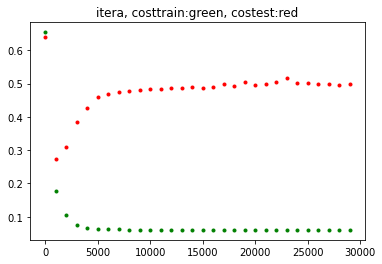

In [8]:
parameters = model(X,Y,Xtest,Ytest,0.3,lambd = 0,keep_prob = 0.86,num_iterations = 30000)

A3  [[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 9.14701415e-04
  9.14701415e-04 9.14701415e-04]]


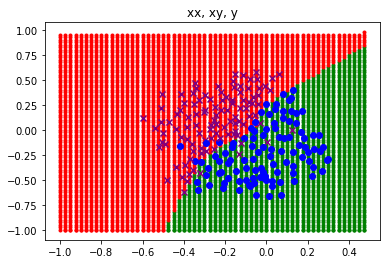

In [9]:
A0 = np.zeros((n0,6400))
for i in range(60):
    for j in range(80):
        A0[0][i * 79 + j] = i * 0.025 - 1
        A0[1][i * 79 + j] = j * 0.025 - 1
A3, cache = forwardprop(A0,parameters)
print("A3 ",A3)
for i in range(60):
    for j in range(80):
        if(A3[0][i * 79 + j] > 0.5):
            plt.scatter(A0[0][i * 79 + j],A0[1][i * 79 + j], c = "red", marker = ".")
        else:
            plt.scatter(A0[0][i * 79 + j],A0[1][i * 79 + j], c = "green", marker = ".")
A0 = X
for i in range(0,A0.shape[1] - 1):
    if(Y[0][i] < 0.5):
        plt.scatter(A0[0][i],A0[1][i], c = "blue", marker = "o");
    else:
        plt.scatter(A0[0][i],A0[1][i], c = "purple", marker = "x");
plt.title("xx, xy, y")
plt.show()